The CIFAR-100 dataset: download and pre-processing
============================

The CIFAR-100 dataset can be downloaded at [www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html) and it is a single compressed file containing serialized numpy arrays. You can also download the dataset directly from the following link:

- [cifar-100-python.tar.gz](https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz): test and training sets (161 MB)

The archive contains three files: *meta*, *test*, *train*. Each of these files is a Python "pickled" object produced with cPickle. The pickle files can be easilly deserialized using the following function:

In [ ]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict


The unpickle() method reuturns a dictionary of elements. Using `unpickle()` on the file *meta* we obtain:

**fine_label_names**: a 100 element list which gives meaningful names to the numeric labels in the labels array described above. For example, fine_label_names[0] == "apple", fine_label_names[1] == "aquarium_fish", fine_label_names[99] == "worm", etc.

**coarse_label_names**: a 20 superclasses list. coarse_label_names[0] == "aquatic_mammals",  coarse_label_names[19] == "vehicles_2"

In [ ]:
my_dict = unpickle("./meta")
fine_label_names = my_dict["fine_label_names"]
coarse_label_names = my_dict["coarse_label_names"]
print("Fine labels: ")
print fine_label_names
print("\n Coarse labels: ")
print coarse_label_names

The *train* file contain the following arrays:

**data**: numpy array (shape: 50000x3072) of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels**: list of 50000 numbers in the range 0-99. The number at index i indicates the label of the ith image in the array data.

To continue this tutorial you need to open the CIFAR-100 archive, extract the files and copy them into the same folder of this notebook. Once you did this you can proceed with the next step:

In [ ]:
my_dict = unpickle("./train")
for key, value in my_dict.items() :
    print (key)

print("\nData shape:")
data = my_dict["data"]
print(data.shape)

print("\nLabels shape:")
fine_labels = my_dict["fine_labels"]
print(len(fine_labels))

Pre-processing in Numpy
----------------------------

Using **numpy** and **matplotlib** it is possible to pick a random image from the training set and show it. In this example I will take the RGB channels and I will reshape and stack them, then through matplotlib I will display the resulting image:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

training_set = my_dict["data"]
random_int = np.random.randint(0,50000)
image_array = training_set[random_int]
image_R = np.reshape(image_array[0:1024], (32,32))
image_G = np.reshape(image_array[1024:2048], (32,32))
image_B = np.reshape(image_array[2048:4096], (32,32))
image = np.dstack((image_R, image_G, image_B))

fine_labels = my_dict["fine_labels"][random_int]
fine_label_name = fine_label_names[fine_labels]

print fine_label_name
plt.imshow(image)
plt.show()

Pre-processing in Tensorflow
---------------------------------

In **tensorflow** we can easily manage the dataset. If all of your input data fit in memory (like in this case), the simplest way to create a dataset from them is to convert them to `tf.Tensor` objects and use `Dataset.from_tensor_slices()`. A `tf.data.Dataset` represents a sequence of elements, in which each element contains one or more Tensor objects. For example, in an image-based pipeline, an element might be a single training example, with a pair of tensors representing the image and a label.

In [ ]:
import tensorflow as tf

tf_dataset = tf.data.Dataset.from_tensor_slices((my_dict["data"], my_dict["fine_labels"]))

Using tensorflow it is also possible to apply a **map function** to the dataset. The map function allows us to sequentially reshape the images and to create one-hot-vector target from a single integer label. The map iterates all the elements stored into the dataset, and uses an external function to parse the data. Into the parse function it can be possible to manipulate the image (e.g. standardisation, rotation, saturation, etc) using the `tf.image` utilities.

In [ ]:
def _parse_function(image_array, label):
    label = tf.cast(label, tf.int32)
    image_R = tf.reshape(image_array[0:1024], [32, 32])
    image_G = tf.reshape(image_array[1024:2048], [32, 32])
    image_B = tf.reshape(image_array[2048:4096], [32, 32])
    image = tf.stack([image_R, image_G, image_B], axis=2)
    #Here it may be possible to apply image manipulation
    #Uncomment and return if you want one-hot encoding
    #label_one_hot = tf.one_hot(label, depth=10)
    return image, label

tf_dataset = tf_dataset.map(_parse_function) #parsing all the elements
tf_dataset = tf_dataset.shuffle(50000) #shuffling all the elements
print(tf_dataset.output_types)
print(tf_dataset.output_shapes)

Once you have built a `Dataset` to represent your input data, the next step is to create an `Iterator` to access elements from that dataset. The `tf.data` API currently supports the following iterators, in increasing level of sophistication:

- one-shot
- initializable
- reinitializable
- feedable

A **one-shot** iterator is the simplest form of iterator, which only supports iterating once through a dataset, with no need for explicit initialization. One-shot iterators handle almost all of the cases that the existing queue-based input pipelines support. I can be initialized using the method `make_one_shot_iterator()`. The iterator can be combined with the `batch()` method in order to get a **batch** of elements that we can use to feed the model:

In [ ]:
batch_size = 32
tf_batch = tf_dataset.batch(batch_size)
print(tf_batch.output_types)
print(tf_batch.output_shapes)

#the iterator is created, it will take batch_size elements from the dataset
iterator = tf_batch.make_one_shot_iterator()
#every time next_element is called batch_size new elements are taken
next_element = iterator.get_next()

with tf.Session() as sess:
    #print(sess.run(next_element))
    #print(sess.run(next_element))
    features, labels = sess.run(next_element) #this is how you can get the features and labels back

Just to be sure we did not mess up with the dataset after all the previous operation, we can display a random image taken from the batch and check if it is corrupted. We can also print the associated label to see if it matches:

In [ ]:
random_int = np.random.randint(batch_size)
image = features[random_int,:,:,:]
label = labels[random_int]
label_name = fine_label_names[label]
print(label)
print(label_name)
plt.imshow(image)
plt.show()    

Complete pipeline in Tensorflow
-------------------------------------

Now it is time to stich everything togheter and create a tensorflow pipeline to load the entire CIFAR-100 dataset and use it for training a model. This session is separated from the previous parts and can run independently from other cells.

In [ ]:
import tensorflow as tf
import numpy as np

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def _parse_function(image_array, label):
    label = tf.cast(label, tf.int32)
    image_R = tf.reshape(image_array[0:1024], [32, 32])
    image_G = tf.reshape(image_array[1024:2048], [32, 32])
    image_B = tf.reshape(image_array[2048:4096], [32, 32])
    image_stack = tf.stack([image_R, image_G, image_B], axis=2)
    #Here the image is standardised through tf.image
    image = tf.image.per_image_standardization(image_stack)
    #label_one_hot = tf.one_hot(label, depth=10)
    return image, label

#Load the test set
print "Processing test set..."
my_dict = unpickle("./test")
tf_test_dataset = tf.data.Dataset.from_tensor_slices((my_dict["data"], my_dict["fine_labels"]))
#Concatenate all the 5 batches in a single training dataset
print "Processing train set..."
my_dict = unpickle("./train")
tf_train_dataset = tf.data.Dataset.from_tensor_slices((my_dict["data"], my_dict["fine_labels"]))

#Parsing all the elements
print "Parsing the datasets..."
tf_test_dataset = tf_test_dataset.map(_parse_function)
tf_train_dataset = tf_train_dataset.map(_parse_function) 

#Shuffling the test set
print "Shuffling test dataset..."
tf_test_dataset = tf_test_dataset.shuffle(buffer_size=50000)
print "done!"

#Printing type and shape of the dataset
print "Test dataset:"
print(tf_test_dataset.output_types)
print(tf_test_dataset.output_shapes)
print "Train dataset:"
print(tf_train_dataset.output_types)
print(tf_train_dataset.output_shapes)

Now we have **two datasets**, one for training and one for testing. You should notice that in the `_parse_function()` I applied a `tf.image.per_image_standardization()` that produced normalised `tf.float32` matrices. The **standardisation** linearly scales image to have zero mean and unit norm. It is important to use a per-image normalisation instead of a batch or dataset standardisation. If the images are standardised using information from a large set we are leaking information into our dataset. Once the model is trained we won't be able to normalize over all of our future data points.

In [ ]:
with tf.name_scope('dataset'):
    batch_size = 32
    num_epochs = 5
    tf_train_dataset = tf_train_dataset.batch(batch_size)
    tf_train_dataset = tf_train_dataset.repeat(num_epochs)
    iterator = tf_train_dataset.make_one_shot_iterator()
    next_batch_imgs, next_batch_labels = iterator.get_next()

Now we have done with the graph and we can initialize a session to sample batches and use them:

In [ ]:
sess = tf.Session()

We can use the training dataset declaring an iterator. Then we can use the session and get the features and labels of a batch:

In [ ]:
features, labels = sess.run([next_batch_imgs, next_batch_labels])

Attention: after the standardisation of the images, we will get problems to visualise them with Matplotlib and Numpy. Now the images are normalised `float32` and no more `uint8` for this reason you will see something wired if you try to plot the features (try the code below).

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
my_dict = unpickle("./meta")
labels_names = my_dict["fine_label_names"]
#random_int = np.random.randint(batch_size)
image = features[0,:,:,:]
label = labels[0]
label_name = labels_names[label]
print features.shape
print label_name
plt.imshow(image)
plt.show() 

To solve the issue we can directly use the **tensorboard** image summary. It is very easy to write the images in the summary thanks to the `tf.summary.image()` method. This method takes as input an image (or a batch of images) and display them in the `image` tab of tensorboard.

The code below save a summary in `/tmp/log/`. To visualise the summary it is necessary to start tensorboard. From terminal run the command `tensorboard --logdir=/tmp/log/` and then open the browser to the address written in console. If everything worked correctly you should see some images under the tab `IMAGE`. You can resize them using the checkbox in the top-left corner `Show actual image size`.

First of all we declare a placeholder that will store the features returned by a previous call to `iterator.get_next()`. We need a placeholder because calling the iterator directly through a summary operation would make the batch move forward of one step. Secondly, we create a summary operation that takes the content of the placeholder. The `max_output` parameter sets the number of images that will be displayed from the batch (default is 3). Thirdly, we have to create a summary writer in order to save on our system the tensorflow graph. To make the graph more clear I put everything inside a name scope.

In [ ]:
with tf.name_scope('batch_visualisation'):
    batch_placeholder = tf.placeholder(tf.float32, shape=(batch_size, 32, 32, 3))
    summary_op = tf.summary.image("batch_images", batch_placeholder, max_outputs=batch_size)
    writer = tf.summary.FileWriter("/tmp/log/", sess.graph)

Next we can call the summary operation that will take the latest images in the batch and will write them in the summary. You can repeat the following snippet multimple times, but in order to see new images you have to ask for a new batch using `features, labels = sess.run([next_batch_imgs, next_batch_labels])`.

In [ ]:
summary = sess.run(summary_op, feed_dict={batch_placeholder: features})
writer.add_summary(summary)

Pre-processing using TFRecords
---------------------------------------

Another approach is to convert whatever data you have into a supported format. This approach makes it easier to mix and match data sets and network architectures. The recommended format for TensorFlow is a **TFRecords** file. You write a little program that gets your data, stuffs it in an Example protocol buffer, serializes the protocol buffer to a string, and then writes the string to a TFRecords file.


In [1]:
import tensorflow as tf
import cPickle

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def pickle_to_tfrecord(pickle_list, output_file):
    with tf.python_io.TFRecordWriter(output_file) as record_writer:
        for input_file in pickle_list:
            #Opening the pickle (return a dictionary)
            with open(input_file, 'rb') as fo:
                data_dict = cPickle.load(fo)
            #Store the dictionary data and labels in two variables
            data = data_dict['data']
            labels = data_dict['fine_labels']
            #Each row of data is an image (each element is a byte)
            #Each row of labels is an integer (the single element is an int64)
            for i in range(len(labels)):
                #Getting the data as train feature
                bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[data[i].tobytes()]))
                int64_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[labels[i]]))
                #Stuff the data in an Example buffer
                example = tf.train.Example(features=tf.train.Features(feature={'image': bytes_feature,
                                                                               'label': int64_feature}))
                #Serialize example to string and write in tfrecords
                record_writer.write(example.SerializeToString())

Now we can use the function to read the CIFAR-10 pickle files and store them in a TFRecords file. I will do it two times, one for the training set, the other for the test set.

In [3]:
pickle_to_tfrecord(["./train"],
                  "./cifar100_train.tfrecord")

In [4]:
pickle_to_tfrecord(["./test"], "./cifar100_test.tfrecord")

Having the two TFRecords file we can use again the utilities of `tf.data` and in particular the `TFRecordDataset` class. We can parse the data and recover the `uint8` image from the serialized `string` using the method `tf.decode_raw()`. We apply standardisation as usual and we get the one-hot vector from the label integer class.

In [5]:
def _parse_function(example_proto):
    features = {"image": tf.FixedLenFeature((), tf.string, default_value=""),
               "label": tf.FixedLenFeature((), tf.int64, default_value=0)}
    parsed_features = tf.parse_single_example(example_proto, features)
    image_decoded = tf.decode_raw(parsed_features["image"], tf.uint8) #char -> uint8
    image_R = tf.reshape(image_decoded[0:1024], [32, 32])
    image_G = tf.reshape(image_decoded[1024:2048], [32, 32])
    image_B = tf.reshape(image_decoded[2048:4096], [32, 32])
    image_reshaped = tf.reshape(image_decoded, [32, 32, 3])
    image_stack = tf.stack([image_R, image_G, image_B], axis=2)
    image = tf.image.per_image_standardization(image_stack)
    #label_one_hot = tf.one_hot(parsed_features["label"], depth=10)
    label = parsed_features["label"]
    return image, label

print "Loading the datasets..."
tf_train_dataset = tf.data.TFRecordDataset("./cifar100_train.tfrecord")
print "Parsing the datasets..."
tf_train_dataset = tf_train_dataset.map(_parse_function)
print "Verifying types and shapes..."
print(tf_train_dataset.output_types)
print(tf_train_dataset.output_shapes)

Loading the datasets...
Parsing the datasets...
Verifying types and shapes...
(tf.float32, tf.int64)
(TensorShape([Dimension(32), Dimension(32), Dimension(3)]), TensorShape([]))


In [6]:
with tf.name_scope('dataset'):
    batch_size = 32
    num_epochs = 5
    tf_train_dataset = tf_train_dataset.batch(batch_size)
    tf_train_dataset = tf_train_dataset.repeat(num_epochs)
    iterator = tf_train_dataset.make_one_shot_iterator()
    next_batch_imgs, next_batch_labels = iterator.get_next()

In [7]:
sess = tf.Session()

In [8]:
features, labels = sess.run([next_batch_imgs, next_batch_labels])

19
(32, 32, 32, 3)


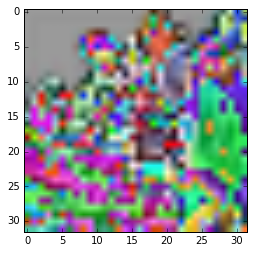

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
image = features[0,:,:,:]
label = labels[0]
print(label)
print(features.shape)
plt.imshow(image)
plt.show() 